# <font color='magenta'>**Proyecto Paralelización**</font>
## <font color='magenta'>**Modelo de Ising 2D: Explorando la paralelización**</font>
## <font color='magenta'>**Santiago Ruiz Piedrahita**</font>

Supongamos $N$ partículas colocadas en una matriz cuadrada. Cada partícula tiene un espín asociado que puede apuntar sólo en dos sentidos, arriba o abajo ($\sigma_i = \pm 1$). Cada una de esas orientaciones se llaman espín de la partícula. El sentido del espín queda determinado mediante la interacción de la partícula con sus vecinas, por fluctuaciones térmicas ($T$) y por campos magnéticos externos ($h$).

El Hamiltoniano del modelo de Ising en una red de $N$ sitios es:

$$\mathcal{H} = -J \sum_{\langle i,j \rangle} \sigma_i \sigma_j - h \sum_{i} \sigma_i$$

Donde:

* $J$ es la constante de acoplamiento o integral de intercambio representa la fuerza de interacción entre los espines vecinos (si $ J > 0 $, la interacción es ferromagnética; si $ J < 0 $, es antiferromagnética).

* $\langle i,j\rangle$ indica la suma sobre pares de sitios vecinos.

* $ h $ es el campo magnético externo.

* $ \sigma_i $ representa los espines individuales ($\sigma_i = \pm 1$)

---

## Distribución de Probabilidad
En el contexto de la mecánica estadística, la probabilidad de que el sistema se encuentre en un estado con energía $\mathcal{H}$ sigue la distribución de Boltzmann:

$$P(S) = \frac{e^{-\mathcal{H}/K_B T}}{Z}$$

donde $K_B$ es la constante de Boltzmann y $Z$ es la función de partición:

$$Z = \sum_S e^{-\mathcal{H}/K_B T}$$

donde la suma recorre todas las posibles configuraciones de espines del sistema.

---

## Propiedades Termodinámicas

La magnetización total del sistema, que mide la alineación promedio de los espines, se define como:

$$M = \sum_i \sigma_i$$

La capacidad calorífica, que describe cómo varía la energía interna del sistema con la temperatura, está dada por:

$$ C_v =  \frac{1}{k_B T^2} (\langle E^2 \rangle - \langle E \rangle^2) $$
  
donde $E$ es la energía total del sistema.

La susceptibilidad magnética, que mide la respuesta del sistema a un campo magnético externo, se define como:

$$ \chi =  \frac{1}{k_B T} (\langle M^2 \rangle - \langle M \rangle^2) $$

Estas cantidades permiten estudiar el comportamiento crítico del sistema, particularmente cerca de la transición de fase ferromagnética en dos dimensiones cuando $J>0$.

## <font color='megenta'>**Fase 1: Implementación del Modelo de Ising 2D.**</font>

1. Se implementa la clase `IsingModel2D`, que modela un sistema cuadrado de espines utilizando interacciones de primer vecino.
  - Solo se trabaja con condiciones de frontera periódicas (pbc), una configuración inicial ordenada, sistemas ferromagnéticos ($J = 1$), en ausencia de campos magnéticos externos ($h \ne 0$). Sin embargo el código cuenta con las herramientas necesarias para hacer los análisis con otras condiciones.
2. Se realiza una prueba inicial del modelo simulando un solo valor de temperatura para $ L = 20 $, verificando la correcta evolución de energía y magnetización.
3. Se lleva a cabo un análisis de convergencia, simulando una temperatura fija y variando el tamaño del sistema $ L $, observando la dependencia de los resultados con el tamaño de la red.
4. Se estudia el cambio de fase del sistema analizando el comportamiento de la energía y la magnetización al variar la temperatura, repitiendo este procedimiento para diferentes valores de $ L $.

## <font color='megenta'>**Fase 2: Computación en paralelo.**</font>

1. Se verifica el correcto funcionamiento de la paralelización mediante la implementación de procesamiento paralelo con `multiprocessing`, asegurando que los resultados coincidan con los obtenidos en serie.
2. Se repite el análisis del cambio de fase utilizando computación en paralelo, evaluando la eficiencia en la ejecución cuando se varían tanto la temperatura como el tamaño del sistema $ L $.

## <font color='megenta'>**Fase 3: Análisis de tiempos de cómputo.**</font>

1. Se realiza un estudio comparativo de los tiempos de ejecución, considerando:
   - Diferencias entre la ejecución en Google Colab y en un servidor local.
   - Comparaciones entre la computación en serie y la computación en paralelo, evaluando las ventajas del paralelismo para diferentes tamaños de sistema.


In [33]:
# Librerias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import multiprocessing as mp
import random
import time
import math
import os

## <font color='lime'>**Nota:**</font>

La ejecución de este proyecto se realizó tanto en Google Colab como en un servidor local. Por ello, cada celda de código en Google Colab cuenta con su correspondiente versión adaptada para su ejecución en el servidor, con algunas modificaciones menores que se explicarán a lo largo de este notebook.

Cabe señalar que únicamente la Fase #3 (referida al análisis de tiempos de cómputo y comparación gráfica de resultados) se basa exclusivamente en los datos previamente generados, sin necesidad de ejecutar nuevamente las simulaciones.

# <font color='red'>**Fase 1: Implementación del Modelo de Ising 2D.**</font>

## <font color='yellow'>**1. Se implementa la clase `IsingModel2D`, que modela un sistema cuadrado de espines utilizando interacciones de primer vecino**</font>

In [10]:
class IsingModel2D:
    """
    Clase para simular el modelo de Ising en 2D con condiciones de frontera periódicas,
    y visualizar configuraciones de espines.
    """

    def __init__(self, L, J=1.0, h=0.0):
        """
        Inicializa el modelo de Ising 2D.

        Parámetros:
        - L: Tamaño de la cuadrícula (sistema LxL)
        - J: Constante de acoplamiento (por defecto 1.0)
        - h: Campo magnético externo (por defecto 0.0)
        """
        self.L = L
        self.N = L * L  # Número total de sitios
        self.J = J
        self.h = h
        self.nbr = self._compute_periodic_neighbors()  # Precalcula los vecinos periódicos

    def _compute_periodic_neighbors(self):
        """
        Calcula los vecinos periódicos para cada sitio de la red.

        Retorna:
        - Un diccionario que asocia cada sitio con sus 4 vecinos.
        """
        return {
            i: ((i // self.L) * self.L + (i + 1) % self.L,   # vecino derecho
                (i + self.L) % self.N,                      # vecino abajo
                (i // self.L) * self.L + (i - 1) % self.L,   # vecino izquierdo
                (i - self.L) % self.N)                      # vecino arriba
            for i in range(self.N)
        }

    def random_state(self):
        """
        Genera un estado inicial aleatorio de espines (+1 o -1).

        Retorna:
        - Lista de tamaño N con espines aleatorios.
        """
        return [random.choice([1, -1]) for _ in range(self.N)]

    def ordered_state(self, value=1):
        """
        Genera un estado inicial ordenado de espines.

        Parámetros:
        - value: Valor del espín deseado (+1 o -1).

        Retorna:
        - Lista de tamaño N con espines iguales.
        """
        return [value] * self.N

    def reshape_state(self, S):
        """
        Convierte una lista 1D de espines en una matriz 2D (LxL).

        Parámetros:
        - S: Estado 1D de espines.

        Retorna:
        - Array de numpy con forma (L, L).
        """
        return np.reshape(S, (self.L, self.L))

    def plot_state(self, S, title="Inicial configuration", cmap_name="coolwarm"):
        """
        Visualiza una configuración de espines usando un mapa de color.

        Parámetros:
        - S: Estado 1D de espines.
        - title: Título de la figura.
        - cmap_name: Nombre del colormap de Matplotlib a usar.

        Guarda la imagen como un archivo PNG.
        """
        fig, ax = plt.subplots(figsize=(6, 6))
        cmap = plt.get_cmap(cmap_name)

        ax.imshow(self.reshape_state(S), extent=[0, self.L, 0, self.L],
                  interpolation="nearest", cmap=cmap, vmin=-1, vmax=1)
        ax.set_title(title, fontsize=16, pad=10)

        down_patch = mpatches.Patch(color=cmap(0.0), label='Spin Down (-1)')
        up_patch = mpatches.Patch(color=cmap(1.0), label='Spin Up (+1)')
        ax.legend(handles=[up_patch, down_patch], loc="upper right", fontsize=10)

        plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300)

    def final_construction(self, S):
        """
        Reconstruye la configuración 2D del estado de espines a partir de un vector 1D.

        Parámetros:
        - S: Estado 1D de espines.

        Retorna:
        - Matriz (lista de listas) que representa la configuración 2D de espines.
        """

        # Función auxiliar: convierte un índice 1D a coordenadas (x, y)
        def x_y(k, L):
            y = k // L
            x = k - y * L
            return x, y

        # Construye la configuración como lista de listas
        def build_conf(S, L, N):
            conf = [[0 for _ in range(L)] for _ in range(L)]
            for k in range(N):
                x, y = x_y(k, L)
                conf[x][y] = S[k]
            return conf

        conf_ = build_conf(S, self.L, self.N)
        return conf_

    def energy(self, S):
        """
        Calcula la energía total del sistema para una configuración dada.

        Parámetros:
        - S: Estado 1D de espines.

        Retorna:
        - Energía total (float).
        """
        E = 0.
        for k in range(self.N):
            E += -self.J * S[k] * sum(S[nn] for nn in self.nbr[k])  # Interacción con vecinos
        E *= 0.5  # Corrige doble conteo
        E -= self.h * sum(S)  # Contribución del campo externo
        return E

    def magnetization(self, S):
        """
        Calcula la magnetización total del sistema.

        Parámetros:
        - S: Estado 1D de espines.

        Retorna:
        - Magnetización total (int).
        """
        return sum(S)

    def simulate(self, S_ini, T, nsteps=20000):
        """
        Simula la evolución del sistema usando el algoritmo de Metropolis.

        Parámetros:
        - S_ini: Estado inicial.
        - T: Temperatura (o array de temperaturas).
        - nsteps: Número de pasos de Monte Carlo.

        Retorna:
        - Listas de energía y magnetización durante la simulación,
        - Estado final (si se simula una sola temperatura),
        - Tiempo total de simulación.
        """
        T = np.atleast_1d(T)  # Convierte T a array si no lo es
        beta = 1.0 / T

        E_total = []
        M_total = []

        start = time.perf_counter()

        for i in range(len(T)):
            E = self.energy(S_ini)
            Energy = [E]
            S = S_ini.copy()
            Magn = [self.magnetization(S)]

            for step in range(nsteps):
                k = random.randint(0, self.N - 1)  # Escoge espín aleatorio

                # Cambio de energía al intentar invertir el espín
                delta_E = 2.0 * S[k] * (sum(S[nn] for nn in self.nbr[k]) + self.h)

                # Criterio de Metropolis
                if random.uniform(0.0, 1.0) < math.exp(-beta[i] * delta_E):
                    S[k] *= -1  # Invierte espín
                    E += delta_E  # Actualiza energía

                Energy.append(E)
                Magn.append(self.magnetization(S))

            E_total.append(Energy)
            M_total.append(Magn)

        end = time.perf_counter()

        # Diferente retorno si es solo una temperatura
        if len(T) == 1:
            return [E_total, M_total, S, end - start]

        return [E_total, M_total, end - start]

    def mean_energy(self, energy_configs):
        """
        Calcula la energía promedio a partir de múltiples configuraciones.

        Parámetros:
        - energy_configs: Lista de listas de energías.

        Retorna:
        - Array de numpy con energías promedio.
        """
        return np.array([np.mean(E) for E in energy_configs])

    def mean_magnetization(self, magnetization_configs):
        """
        Calcula la magnetización promedio a partir de múltiples configuraciones.

        Parámetros:
        - magnetization_configs: Lista de listas de magnetizaciones.

        Retorna:
        - Array de numpy con magnetizaciones promedio.
        """
        return np.array([np.mean(M) for M in magnetization_configs])

    def heat_capacity(self, energy_configs, temperatures):
        """
        Calcula la capacidad calorífica C_V del sistema.

        Parámetros:
        - energy_configs: Lista de listas de energías.
        - temperatures: Array de temperaturas.

        Retorna:
        - Array de numpy con C_V(T).
        """
        K_B = 1.0  # Constante de Boltzmann (en unidades naturales)
        mean_E = self.mean_energy(energy_configs)
        mean_E2 = np.array([np.mean(np.array(E) ** 2) for E in energy_configs])
        C_V = (mean_E2 - mean_E ** 2) / ((temperatures ** 2) * K_B)
        return C_V

    def magnetic_susceptibility(self, magnetization_configs, temperatures):
        """
        Calcula la susceptibilidad magnética chi del sistema.

        Parámetros:
        - magnetization_configs: Lista de listas de magnetizaciones.
        - temperatures: Array de temperaturas.

        Retorna:
        - Array de numpy con chi(T).
        """
        K_B = 1.0  # Constante de Boltzmann (en unidades naturales)
        mean_M = self.mean_magnetization(magnetization_configs)
        mean_M2 = np.array([np.mean(np.array(M) ** 2) for M in magnetization_configs])
        chi = (mean_M2 - mean_M ** 2) / (temperatures * K_B)
        return chi


## <font color='lime'>**Nota código en servidor:**</font>

Para el código puesto en el servidor se eliminan las funciones:

```
def plot_state(self, S, title="Inicial configuration", cmap_name="coolwarm"):

def final_construction(self, S):
```
Esto debido a que el servidor no soporta la parte gráfica.




## <font color='yellow'>**2. Se realiza una prueba inicial del modelo simulando un solo valor de temperatura para $ L = 20 $, verificando la correcta evolución de energía y magnetización.**</font>



Programa de testeo para L = 20
El testeo para L = 20, para T = 5.0, se demora 0.20239 s


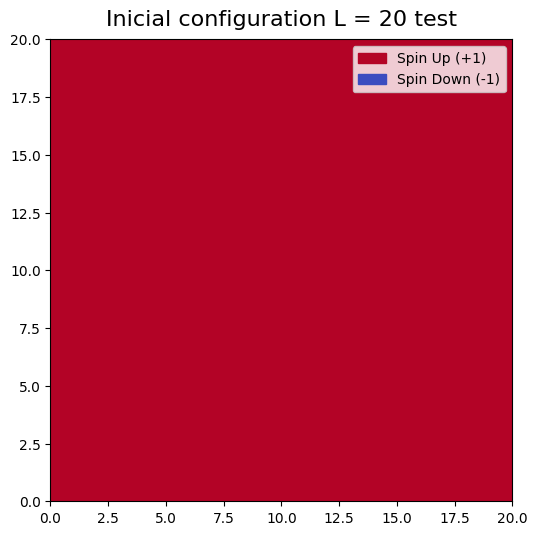

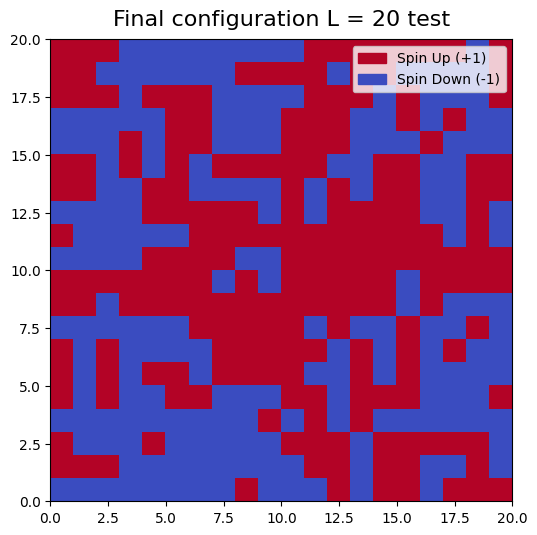

In [11]:
# Se procede con los análisis

# Definimos el tamaño del sistema
L = 20  # Longitud de la red cuadrada (sistema de 200x200 sitios)

# Definimos la temperatura del sistema
Temp = 5.0  # Temperatura a la que se va a simular

# Mensaje en consola para confirmar los parámetros de prueba
print("Programa de testeo para L = {}".format(L))

# Se crea una instancia del modelo de Ising con el tamaño especificado
ising_model_L_20_test = IsingModel2D(L=L)

# Se genera un estado inicial ordenado (todos los espines +1)
S = ising_model_L_20_test.ordered_state()

# Se grafica y guarda la configuración inicial
ising_model_L_20_test.plot_state(S, "Inicial configuration L = 20 test")

# Se realiza la simulación usando el algoritmo de Metropolis
# Se ejecuta nsteps = L * 1000 pasos de Monte Carlo
Energia, Magnetizacion, S_final, time_duration = ising_model_L_20_test.simulate(S, T=Temp, nsteps=L * 1000)

# Se grafica y guarda la configuración final de espines después de la simulación
ising_model_L_20_test.plot_state(ising_model_L_20_test.final_construction(S_final), title="Final configuration L = 20 test")

# Se imprime el tiempo de duración de la simulación
print("El testeo para L = {}, para T = {}, se demora {:.5f} s".format(L, Temp, time_duration))

## <font color='lime'>**Nota código en servidor:**</font>

Para el código puesto en el servidor se eliminan las líneas de gráficación:

```
ising_model_L_20_test.plot_state(S, "Inicial configuration L = 20 test")

ising_model_L_20_test.plot_state(ising_model_L_20_test.final_construction(S_final), title="Final configuration L = 20 test")
```
Esto debido a que el servidor no soporta la parte gráfica.

## <font color='yellow'>**3. Se lleva a cabo un análisis de convergencia, simulando una temperatura fija y variando el tamaño del sistema $ L $, observando la dependencia de los resultados con el tamaño de la red.**</font>


Programa para el conjunto L = [20, 40, 60, 80, 100]

---

Para L = 20, para T = 5.0, con 20000 pasos, se demora 0.16477 s

---

Para L = 40, para T = 5.0, con 40000 pasos, se demora 0.87837 s

---

Para L = 60, para T = 5.0, con 60000 pasos, se demora 2.86949 s

---

Para L = 80, para T = 5.0, con 80000 pasos, se demora 7.55446 s

---

Para L = 100, para T = 5.0, con 100000 pasos, se demora 14.21722 s

---


---



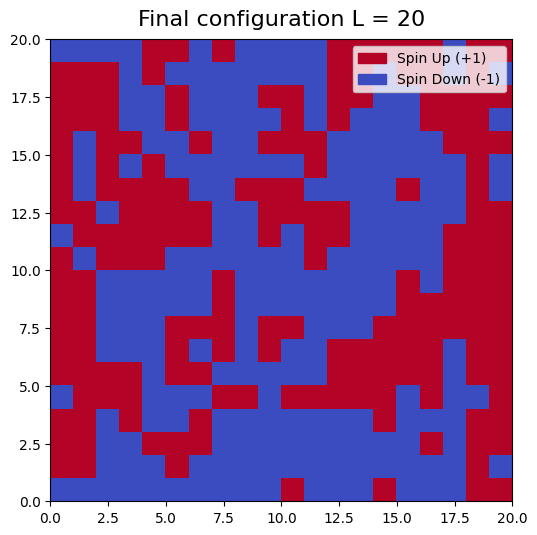

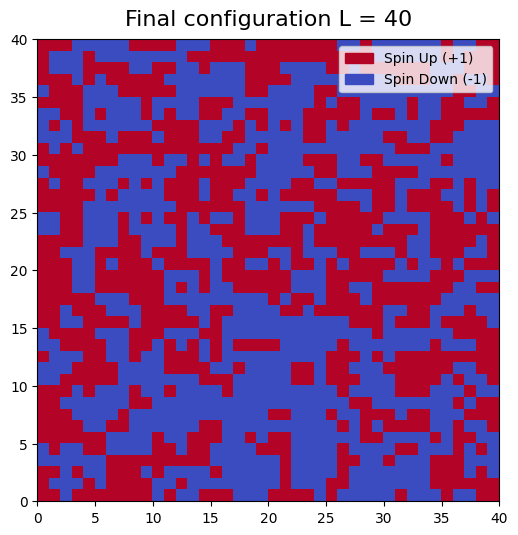

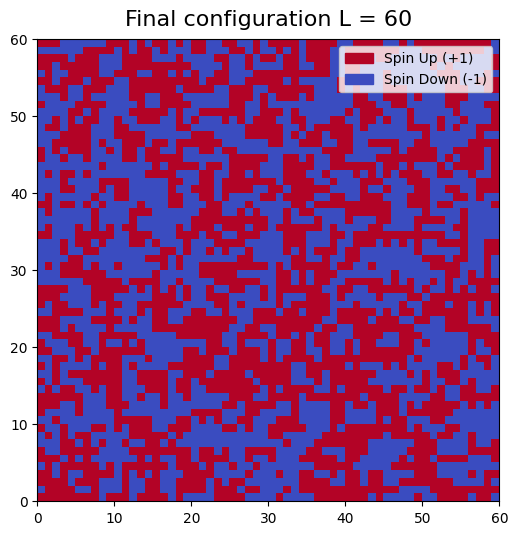

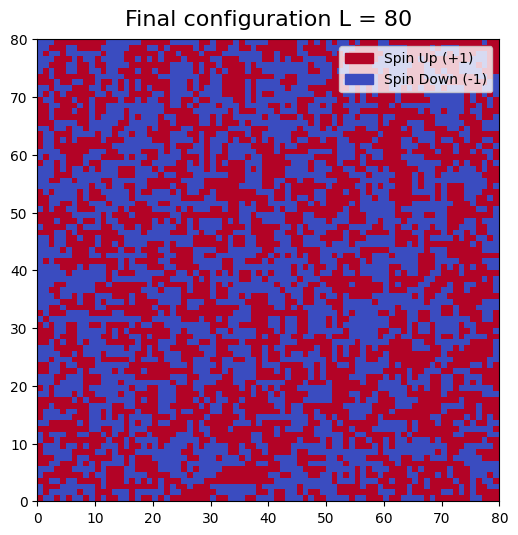

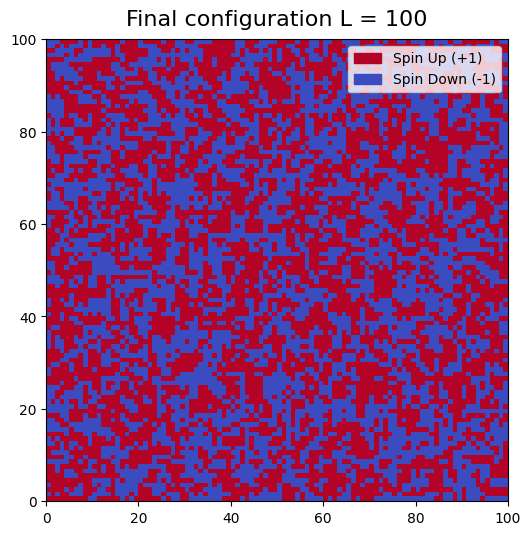

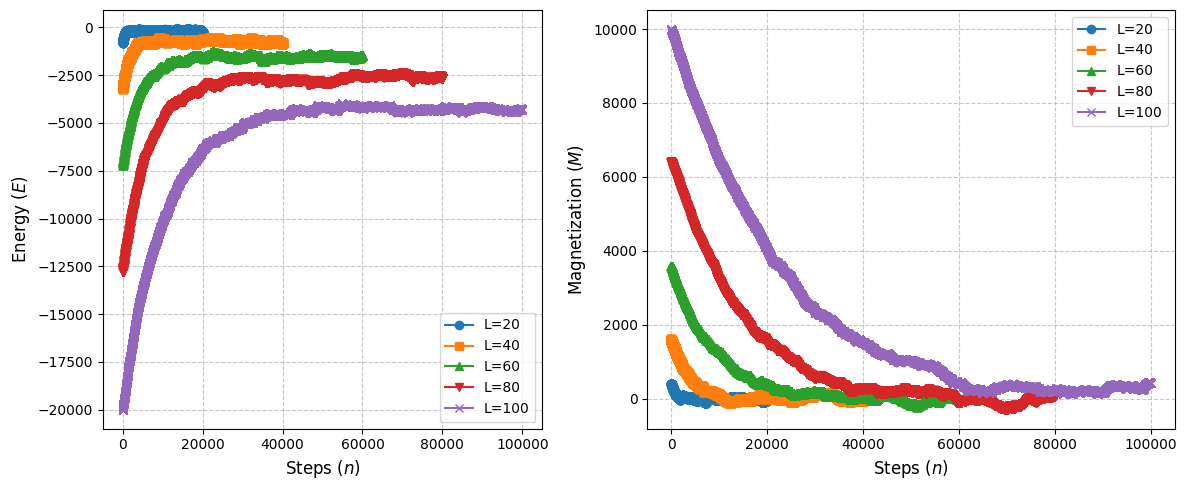

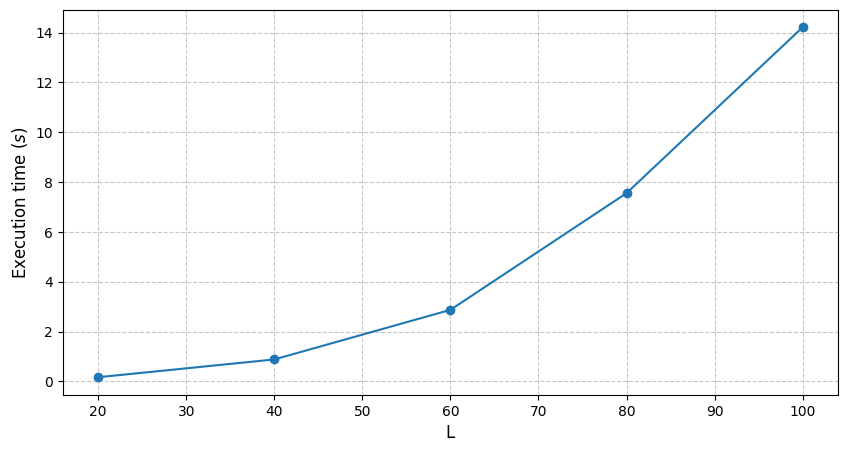

In [12]:
# Definimos los tamaños de red a estudiar y la temperatura
L = [20, 40, 60, 80, 100]  # Tamaños de la red
nsteps = [l * 1000 for l in L]  # Número de pasos de simulación
Temp = 5.0  # Temperatura

print("Programa para el conjunto L = {}".format(L))
print("\n---\n")

# Inicializamos listas para almacenar resultados
energias = []
magnetizaciones = []
tiempos = []

# Diccionario para guardar configuraciones finales
final_configs = {}

# Simulaciones en un bucle
for i, l in enumerate(L):
    ising_model = IsingModel2D(L=l)  # Inicializamos el modelo de Ising
    S_init = ising_model.ordered_state()  # Estado inicial
    energia, magnetizacion, S_final, time_duration = ising_model.simulate(S_init, T=Temp, nsteps=nsteps[i])  # Simulación

    # Guardamos los resultados
    energias.append(energia)
    magnetizaciones.append(magnetizacion)
    tiempos.append(time_duration)
    final_configs[l] = S_final

    # Graficamos la configuración final
    ising_model.plot_state(ising_model.final_construction(S_final), title=f"Final configuration L = {l}")

    # Imprimimos el tiempo de simulación
    print("Para L = {}, para T = {}, con {} pasos, se demora {:.5f} s".format(l, Temp, nsteps[i], time_duration))
    print("\n---\n")

# Gráficas de convergencia de Energía y Magnetización
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})
markers = ['o', 's', '^', 'v', 'x']

# Energía en función de pasos de Monte Carlo
for i, l in enumerate(L):
    axes[0].plot(range(nsteps[i]+1), energias[i][0], label=f"L={l}", linestyle='-', marker=markers[i])
axes[0].set_xlabel("Steps $(n)$", fontsize=12)
axes[0].set_ylabel(r"Energy ($E$)", fontsize=12)
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Magnetización en función de pasos de Monte Carlo
for i, l in enumerate(L):
    axes[1].plot(range(nsteps[i]+1), magnetizaciones[i][0], label=f"L={l}", linestyle='-', marker=markers[i])
axes[1].set_xlabel("Steps $(n)$", fontsize=12)
axes[1].set_ylabel(r"Magnetization ($M$)", fontsize=12)
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)

# Ajustamos el diseño y guardamos la gráfica
plt.tight_layout()
plt.savefig("Convergence.png", dpi=300)

print("\n---\n")

# Gráfica del tiempo de ejecución en función de L
plt.figure(figsize=(10, 5))
plt.plot(L, tiempos, marker='o')
plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("Time_duration.png", dpi=300)

# Guardamos los resultados de tiempos en un archivo CSV
df = pd.DataFrame({'L': L, 'Execution time (s)': tiempos})
df.to_csv("simulation_times_1.csv", index=False)

## <font color='lime'>**Nota código en servidor:**</font>

Para el código puesto en el servidor se eliminan todas las líneas de la parte gráfica.

Esto debido a que el servidor no soporta la parte gráfica.

Programa para el conjunto L $\in$ [5,150] 

Para L = 150, T = 5.0, con 150000 pasos, se demora 45.03211 s


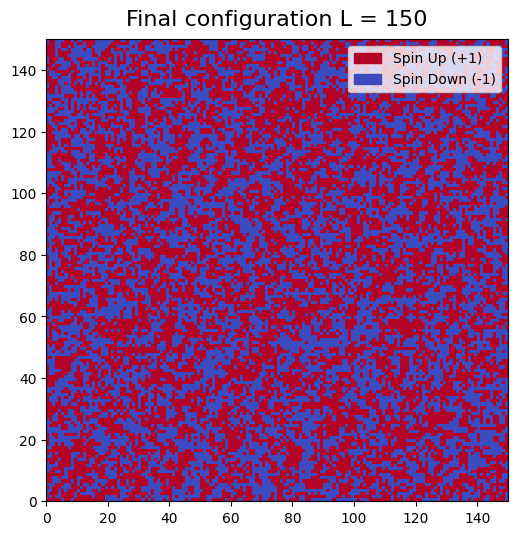

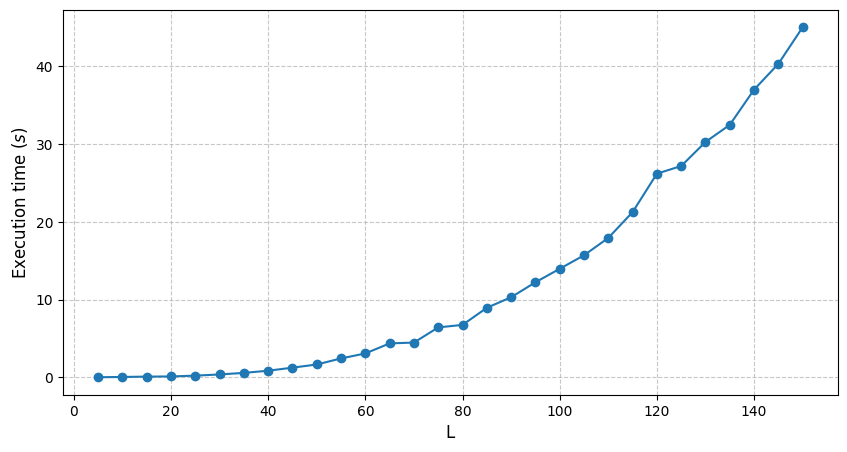

In [13]:
L_values = np.arange(5,155,5)  # Valores de L de 5 a 150
nsteps = [l * 1000 for l in L_values]  # Pasos de simulación para cada L
Temp = 5.0  # Temperatura fija

tiempos_simulacion = []  # Almacena los tiempos de simulación

print(f"Programa para el conjunto L $\in$ [5,150] \n")

# Simulación para cada valor de L
for i, L in enumerate(L_values):
    model = IsingModel2D(L=L) # Inicializamos el modelo de Ising
    S_init = model.ordered_state() # Estado inicial
    Energia, Magnetizacion, S_final, tiempo = model.simulate(S_init, T=Temp, nsteps=nsteps[i]) # simulacion
    tiempos_simulacion.append(tiempo)

    # Si es el último valor de L, grafica el estado final
    if i == len(L_values) - 1:
        model.plot_state(model.final_construction(S_final), title=f"Final configuration L = {L}")
        print(f"Para L = {L}, T = {Temp}, con {nsteps[i]} pasos, se demora {tiempo:.5f} s")

# Gráfica de tiempos de ejecución
plt.figure(figsize=(10, 5))
plt.plot(L_values, tiempos_simulacion, marker='o')
plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("Time_duration_detailed.png", dpi=300)

# Guardar resultados en CSV
df = pd.DataFrame({
    'L': L_values,
    'Execution time (s)': tiempos_simulacion
})
df.to_csv("simulation_times_2.csv", index=False)

## <font color='lime'>**Nota código en servidor:**</font>

Para el código puesto en el servidor se eliminan todas las líneas de la parte gráfica.

Esto debido a que el servidor no soporta la parte gráfica.

## <font color='yellow'>**4. Se estudia el cambio de fase del sistema analizando el comportamiento de la energía y la magnetización al variar la temperatura, repitiendo este procedimiento para diferentes valores de $ L $.**</font>


Programa para el conjunto L = [20, 40, 60, 80, 100] y diferentes valores de temperatura.

---

Para L = 20, para 30 valores de temperatura, con 20000 pasos Montecarlo, se demora 4.16232 s

---

Para L = 40, para 30 valores de temperatura, con 40000 pasos Montecarlo, se demora 27.18171 s

---

Para L = 60, para 30 valores de temperatura, con 60000 pasos Montecarlo, se demora 95.00949 s

---

Para L = 80, para 30 valores de temperatura, con 80000 pasos Montecarlo, se demora 200.94370 s

---

Para L = 100, para 30 valores de temperatura, con 100000 pasos Montecarlo, se demora 381.28127 s

---



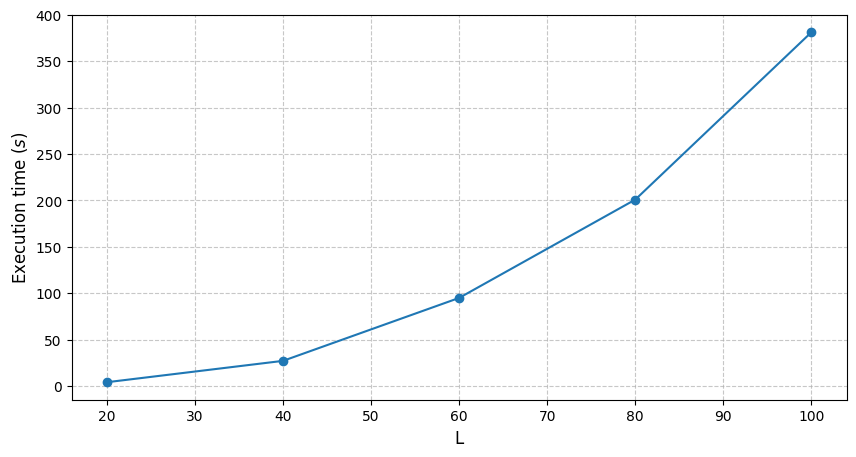

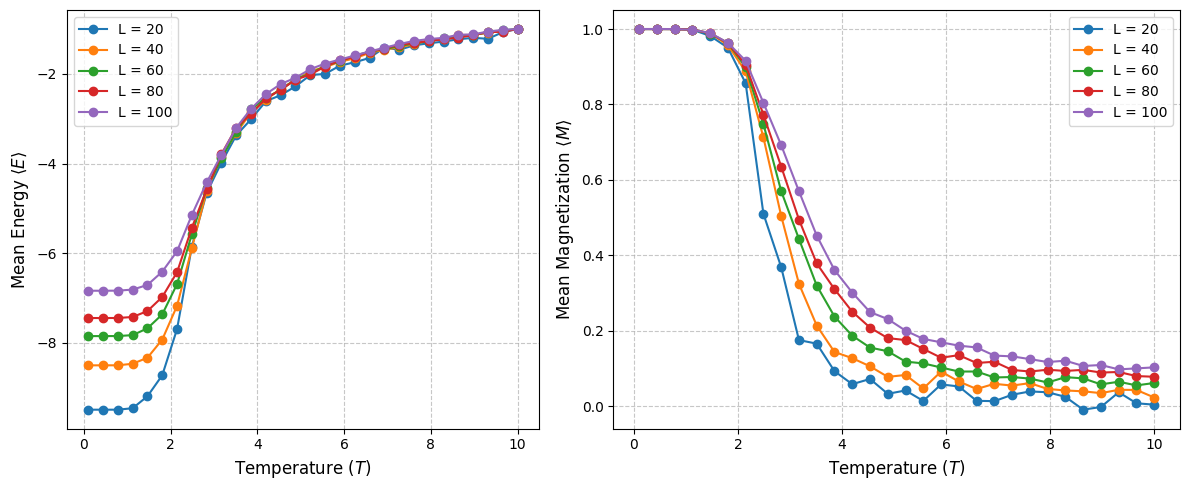

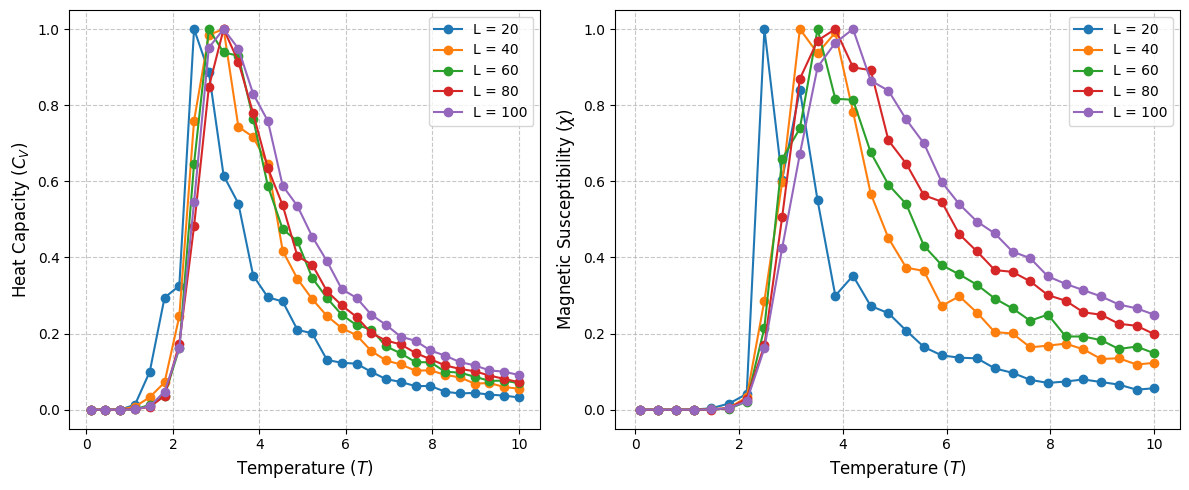

In [17]:
# Definimos los tamaños de red a estudiar y las temperaturas
L = [20, 40, 60, 80, 100]  # Tamaños de la red
nsteps = [l * 1000 for l in L]  # Número de pasos para cada tamaño de red
Temp = np.linspace(0.1, 10, 30)  # Rango de temperaturas a estudiar

print("Programa para el conjunto L = {} y diferentes valores de temperatura.".format(L))

print("\n---\n")

# Inicializamos listas para guardar los tiempos de simulación, energías y magnetizaciones
tiempos = []
energias = []
magnetizaciones = []

# Usamos un bucle para iterar sobre los valores de L
for i, l in enumerate(L):
    # Inicializamos el modelo de Ising para cada valor de L
    ising_model = IsingModel2D(L=l)
    S_init = ising_model.ordered_state()  # Estado inicial ordenado
    # Realizamos la simulación para cada valor de temperatura
    Energia, Magnetizacion, time_duration = ising_model.simulate(S_init, T=Temp, nsteps=nsteps[i])

    # Imprimimos el tiempo de simulación para cada valor de L
    print("Para L = {}, para {} valores de temperatura, con {} pasos Montecarlo, se demora {:.5f} s".format(l, len(Temp), nsteps[i], time_duration))
    print("\n---\n")

    # Guardamos el tiempo de simulación, energía y magnetización en las listas
    tiempos.append(time_duration)
    energias.append(Energia)  # Guardar la energía para este valor de L
    magnetizaciones.append(Magnetizacion)  # Guardar la magnetización para este valor de L

# Graficamos los tiempos de ejecución para cada tamaño de red L
plt.figure(figsize=(10, 5))
plt.plot(L, tiempos, marker='o')
plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("Time_duration_temp.png", dpi=300)

# Creamos un DataFrame con los tiempos de simulación y los tamaños de red L
df = pd.DataFrame({
    'L': L,
    'Execution time (s)': tiempos})

# Guardamos los resultados de tiempos en un archivo CSV
df.to_csv("simulation_times_3.csv", index=False)

# Graficamos la energía y magnetización para cada valor de L en función de la temperatura
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Energía promedio en función de la temperatura para cada L
for i, l in enumerate(L):
    # Calculamos la energía media para cada temperatura
    energias_medias = ising_model.mean_energy(energias[i]) / abs(max(ising_model.mean_energy(energias[i])))
    axes[0].plot(Temp, energias_medias, label=f"L = {l}", linestyle='-', marker='o')
axes[0].set_xlabel("Temperature $(T)$", fontsize=12)
axes[0].set_ylabel(r"Mean Energy $\langle E \rangle$", fontsize=12)
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Magnetización promedio en función de la temperatura para cada L
for i, l in enumerate(L):
    # Calculamos la magnetización media para cada temperatura
    magnetizaciones_medias = ising_model.mean_magnetization(magnetizaciones[i]) / abs(max(ising_model.mean_magnetization(magnetizaciones[i])))
    axes[1].plot(Temp, magnetizaciones_medias, label=f"L = {l}", linestyle='-', marker='o')
axes[1].set_xlabel("Temperature $(T)$", fontsize=12)
axes[1].set_ylabel(r"Mean Magnetization $\langle M \rangle$", fontsize=12)
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)

# Ajustamos el diseño de las gráficas y las guardamos
plt.tight_layout()
plt.savefig("EnergiaYMagnetizacion.png", dpi=300)

# Graficamos la capacidad calorífica y la susceptibilidad magnética para cada L
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Capacidad calorífica en función de la temperatura para cada L
for i, l in enumerate(L):
    axes[0].plot(Temp, ising_model.heat_capacity(energias[i], Temp)/abs(max(ising_model.heat_capacity(energias[i], Temp))), label=f"L = {l}", linestyle='-', marker='o')
axes[0].set_xlabel("Temperature $(T)$", fontsize=12)
axes[0].set_ylabel(r"Heat Capacity ($C_V$)", fontsize=12)
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Susceptibilidad magnética en función de la temperatura para cada L
for i, l in enumerate(L):
    axes[1].plot(Temp, ising_model.magnetic_susceptibility(magnetizaciones[i], Temp)/abs(max(ising_model.magnetic_susceptibility(magnetizaciones[i], Temp))), label=f"L = {l}", linestyle='-', marker='o')
axes[1].set_xlabel("Temperature $(T)$", fontsize=12)
axes[1].set_ylabel(r"Magnetic Susceptibility ($\chi$)", fontsize=12)
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)

# Ajustamos el diseño de las gráficas y las guardamos
plt.tight_layout()
plt.savefig("heat.png", dpi=300)

## <font color='lime'>**Nota código en servidor:**</font>

Para el código puesto en el servidor se eliminan todas las líneas de la parte gráfica.

Se añaden archivos de *pandas* para guardar los datos de magnetización, energia, capacidad calorifica y suceptibilidad magnética. Para posteriormente gráficarlos.

Esto debido a que el servidor no soporta la parte gráfica.

# <font color='red'>**Fase 2: Computación en paralelo.**</font>

## <font color='yellow'>**1. Se verifica el correcto funcionamiento de la paralelización mediante la implementación de procesamiento paralelo con `multiprocessing`, asegurando que los resultados coincidan con los obtenidos en serie.**</font>



In [18]:
# Ahora vamos con la paralelizacion
import multiprocessing as mp

# imprimimos el número de procesadores
print("Number of processors: ", mp.cpu_count())

Number of processors:  2


Programa para L = 20 y 30 valores de temperatura

Número de procesadores disponibles: 2

---

[PID 17055] Iniciando simulación para T = 0.10
[PID 17056] Iniciando simulación para T = 1.47
[PID 17055] Terminó    simulación para T = 0.10 - Duración: 0.22 s
[PID 17056] Terminó    simulación para T = 1.47 - Duración: 0.21 s


[PID 17056] Iniciando simulación para T = 1.81[PID 17055] Iniciando simulación para T = 0.44

[PID 17055] Terminó    simulación para T = 0.44 - Duración: 0.19 s

[PID 17055] Iniciando simulación para T = 0.78[PID 17056] Terminó    simulación para T = 1.81 - Duración: 0.21 s


[PID 17056] Iniciando simulación para T = 2.15
[PID 17055] Terminó    simulación para T = 0.78 - Duración: 0.20 s

[PID 17056] Terminó    simulación para T = 2.15 - Duración: 0.20 s

[PID 17055] Iniciando simulación para T = 1.12
[PID 17056] Iniciando simulación para T = 2.49
[PID 17055] Terminó    simulación para T = 1.12 - Duración: 0.21 s

[PID 17056] Terminó    simulación para T = 2.49 - Dura

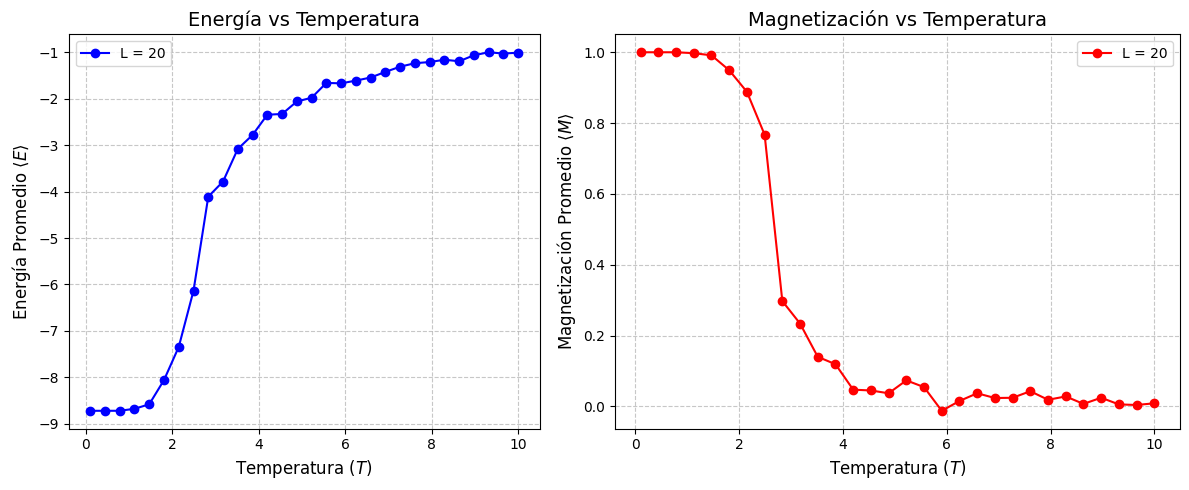

In [19]:
# --- Parámetros de la simulación ---
L = [20, 40, 60, 80, 100]  # Diferentes tamaños de la red
nsteps = [l * 1000 for l in L]  # Número de pasos de simulación para cada tamaño de red
Temp = np.linspace(0.1, 10, 30)  # Rango de temperaturas a estudiar (desde 0.1 hasta 10, con 30 valores)

# Mostrar los parámetros que se están utilizando
print("Programa para L = {} y {} valores de temperatura\n".format(L[0], len(Temp)))
print("Número de procesadores disponibles:", mp.cpu_count())

# --- Función para simular la dinámica de Ising para una temperatura dada ---
def simulate_single_temp(T):
    """
    Simula el modelo de Ising para una temperatura T, tamaño de sistema l y número de pasos.
    Args:
        T: Temperatura en la simulación.
        l: Tamaño del sistema L.
        steps: Número de pasos Monte Carlo.
    Returns:
        Tuple: Contiene la temperatura, energía, magnetización, y tiempo de simulación.
    """
    pid = os.getpid()  # Identificador de proceso para verificar la paralelización
    print(f"[PID {pid}] Iniciando simulación para T = {T:.2f}")

    # Crear el modelo de Ising 2D con tamaño L[0] (se usa el primer tamaño de la lista L)
    model = IsingModel2D(L=L[0])
    S = model.ordered_state()  # Estado inicial ordenado (todo positivo)

    # Ejecutar la simulación
    Energia, Magnetizacion, S_final, time_duration = model.simulate(S, T=T, nsteps=nsteps[0])

    print(f"[PID {pid}] Terminó    simulación para T = {T:.2f} - Duración: {time_duration:.2f} s\n")

    # Retornar los resultados de la simulación
    return T, Energia, Magnetizacion, time_duration

print("\n---\n")

# analisis solo para L = 20

# --- Medir el tiempo de ejecución en paralelo ---
start_time = time.time()

# Crear un pool de procesos para ejecutar la simulación en paralelo
with mp.Pool(processes=mp.cpu_count()) as pool:
    results = pool.map(simulate_single_temp, Temp)  # Ejecutar la simulación para cada valor de temperatura en Temp

end_time = time.time()  # Medir el tiempo final

# --- Procesar los resultados de la simulación ---
# Extraer los resultados de la simulación en listas separadas
Temps = [res[0] for res in results]  # Temperaturas
Energias = [res[1] for res in results]  # Energías
Magnetizaciones = [res[2] for res in results]  # Magnetizaciones
Tiempos_internos = [res[3] for res in results]  # Tiempos de simulación internos

# Mostrar los resultados de tiempo total y tiempo promedio por simulación
print("\n--- Resultados ---")
print("Tiempo total externo: {:.5f} s".format(end_time - start_time))
print("Tiempo interno promedio: {:.5f} s".format(np.mean(Tiempos_internos)))

# --- Crear las gráficas ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Promedio de la energía y magnetización para cada temperatura
energias_medias = np.array([np.mean(e) for e in Energias])
magnetizaciones_medias = np.array([np.mean(m) for m in Magnetizaciones])

# Gráfica de energía vs temperatura
axes[0].plot(Temps, energias_medias / abs(max(energias_medias)), label=f"L = {L[0]}", linestyle='-', marker='o', color='b')
axes[0].set_xlabel("Temperatura $(T)$", fontsize=12)
axes[0].set_ylabel(r"Energía Promedio $\langle E \rangle$", fontsize=12)
axes[0].set_title("Energía vs Temperatura", fontsize=14)
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Gráfica de magnetización vs temperatura
axes[1].plot(Temps, magnetizaciones_medias / abs(max(magnetizaciones_medias)), label=f"L = {L[0]}", linestyle='-', marker='o', color='r')
axes[1].set_xlabel("Temperatura $(T)$", fontsize=12)
axes[1].set_ylabel(r"Magnetización Promedio $\langle M \rangle$", fontsize=12)
axes[1].set_title("Magnetización vs Temperatura", fontsize=14)
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)

# Ajustar el diseño de las gráficas
plt.tight_layout()

# Mostrar la figura en pantalla
plt.show()

## <font color='lime'>**Nota código en servidor:**</font>

Esta celda de código no se replicó en el servidor, dado que se usó de manera visual para comprobar cuál era el funcionamiento interno de multiprocesing.

## <font color='yellow'>**2. Se repite el análisis del cambio de fase utilizando computación en paralelo, evaluando la eficiencia en la ejecución cuando se varían tanto la temperatura como el tamaño del sistema $ L $.**</font>




Programa para el conjunto L = [20, 40, 60, 80, 100] y diferentes valores de temperatura.
Número de procesadores: 2
Para L = 20, para 30 valores de temperatura, con 20000 pasos Montecarlo:
Tiempo total externo: 4.99257 s
Tiempo interno promedio: 0.31133 s

---

Para L = 40, para 30 valores de temperatura, con 40000 pasos Montecarlo:
Tiempo total externo: 22.94113 s
Tiempo interno promedio: 1.45749 s

---

Para L = 60, para 30 valores de temperatura, con 60000 pasos Montecarlo:
Tiempo total externo: 74.09563 s
Tiempo interno promedio: 4.71338 s

---

Para L = 80, para 30 valores de temperatura, con 80000 pasos Montecarlo:
Tiempo total externo: 169.36407 s
Tiempo interno promedio: 10.84841 s

---

Para L = 100, para 30 valores de temperatura, con 100000 pasos Montecarlo:
Tiempo total externo: 328.86357 s
Tiempo interno promedio: 21.12086 s

---



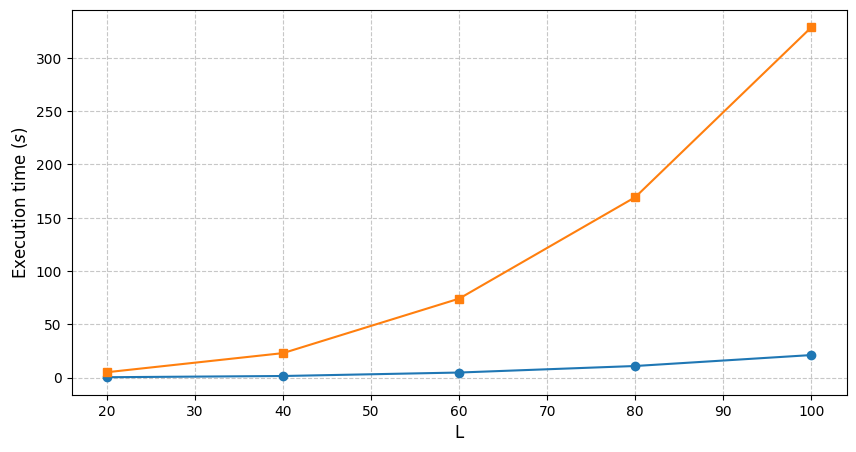

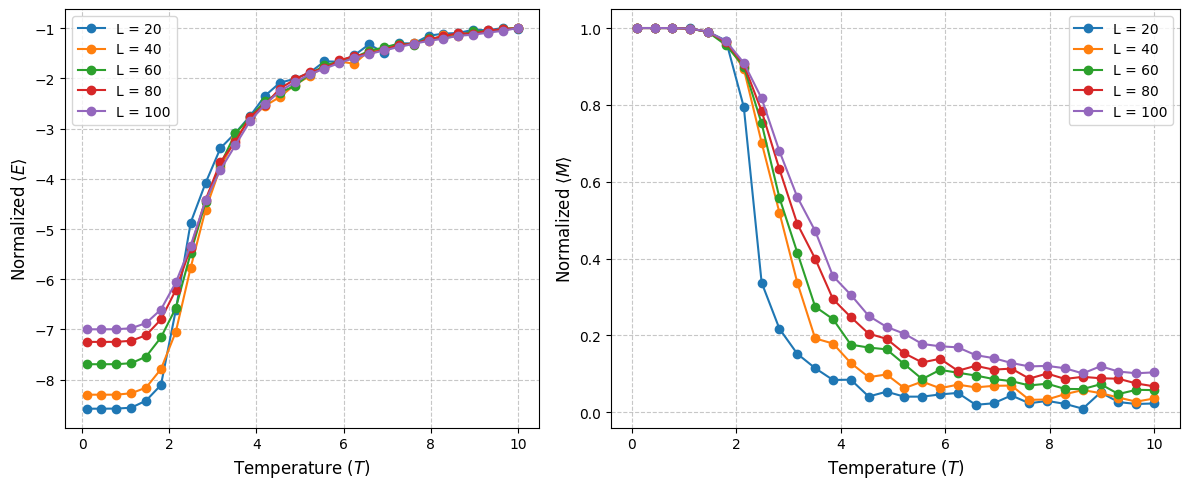

In [20]:
# --- Parámetros ---
L = [20, 40, 60, 80, 100]  # Tamaños del sistema
nsteps = [l * 1000 for l in L]  # Número de pasos Montecarlo
Temp = np.linspace(0.1, 10, 30)  # Temperaturas
args = [[(T, l, steps) for T in Temp] for l, steps in zip(L, nsteps)]  # Argumentos para cada L

print("Programa para el conjunto L = {} y diferentes valores de temperatura.".format(L))
print("Número de procesadores:", mp.cpu_count())

# --- Función que se ejecuta en paralelo ---
def simulate_single_temp(T, l, steps):
    """
    Simula el modelo de Ising para una temperatura T, tamaño de sistema l y número de pasos.
    Args:
        T: Temperatura en la simulación.
        l: Tamaño del sistema L.
        steps: Número de pasos Monte Carlo.
    Returns:
        Tuple: Contiene la temperatura, energía, magnetización, y tiempo de simulación.
    """
    model = IsingModel2D(L=l)
    S = model.ordered_state()
    Energia, Magnetizacion, S_final, time_duration = model.simulate(S, T=T, nsteps=steps)
    return T, Energia, Magnetizacion, time_duration

# Inicialización de listas para almacenar los resultados de tiempos de ejecución y otros datos
Tiempos_internos = []
Tiempos_externos = []
Energias_medias = {}
Magnetizaciones_medias = {}

# Bucle para iterar sobre los diferentes tamaños L
for i, l in enumerate(L):
    # --- Medir tiempo externo ---
    start_time = time.time()

    # Usamos multiprocessing para paralelizar la simulación para cada valor de L
    with mp.Pool(processes=mp.cpu_count()) as pool:
        results = pool.starmap(simulate_single_temp, args[i])

    end_time = time.time()

    # --- Procesar resultados ---
    tiempo_total_externo = end_time - start_time
    Temps = [res[0] for res in results]
    Energias = [res[1] for res in results]
    Magnetizaciones = [res[2] for res in results]
    Tiempos_internos_L = [res[3] for res in results]
    Tiempos_internos_L_mean = np.mean(Tiempos_internos_L)

    # Normalizamos las energías y magnetizaciones
    energias_medias = np.array([np.mean(e) for e in Energias])
    magnetizaciones_medias = np.array([np.mean(m) for m in Magnetizaciones])

    # Almacenamos los resultados para cada valor de L
    Tiempos_internos.append(Tiempos_internos_L_mean)
    Tiempos_externos.append(tiempo_total_externo)
    Energias_medias[f"L={l}"] = energias_medias / abs(max(energias_medias))
    Magnetizaciones_medias[f"L={l}"] = magnetizaciones_medias / abs(max(magnetizaciones_medias))

    # Imprimir los resultados
    print(f"Para L = {l}, para {len(Temp)} valores de temperatura, con {nsteps[i]} pasos Montecarlo:")
    print(f"Tiempo total externo: {tiempo_total_externo:.5f} s")
    print(f"Tiempo interno promedio: {Tiempos_internos_L_mean:.5f} s")
    print("\n---\n")

# --- Gráficas ---

# Gráfica de tiempos de duración
plt.figure(figsize=(10, 5))
plt.plot(L, Tiempos_internos, marker='o', label="Internal times")
plt.plot(L, Tiempos_externos, marker='s', label="External times")
plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("Time_duration_paralelizacion.png", dpi=300)

# Crear un DataFrame con los tiempos
df = pd.DataFrame({
    'L': L,
    'Execution internal time (s)': Tiempos_internos,
    'Execution external time (s)': Tiempos_externos
})

# Guardar el DataFrame en un archivo CSV
df.to_csv("simulation_times_4.csv", index=False)

# --- Graficar Energía y Magnetización ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Graficar la energía
for l in L:
    axes[0].plot(Temps, Energias_medias[f"L={l}"], label=f"L = {l}", linestyle='-', marker='o')
axes[0].set_xlabel("Temperature $(T)$", fontsize=12)
axes[0].set_ylabel(r"Normalized $\langle E \rangle$", fontsize=12)
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Graficar la magnetización
for l in L:
    axes[1].plot(Temps, Magnetizaciones_medias[f"L={l}"], label=f"L = {l}", linestyle='-', marker='o')
axes[1].set_xlabel("Temperature $(T)$", fontsize=12)
axes[1].set_ylabel(r"Normalized $\langle M \rangle$", fontsize=12)
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)

# Ajustar espaciado y guardar la figura
plt.tight_layout()
plt.savefig("EnergiaYMagnetizacion_paralelizacion.png", dpi=300)


## <font color='lime'>**Nota código en servidor:**</font>

Para el código puesto en el servidor se eliminan todas las líneas de la parte gráfica.

Se añaden archivos de *pandas* para guardar los datos de magnetización, energia, capacidad calorifica y suceptibilidad magnética. Para posteriormente gráficarlos.

Esto debido a que el servidor no soporta la parte gráfica.

## <font color='lime'>**Código extra en el servidor:**</font>

Se creó una modificación del anterior código, en el servidor; el cual, se le aumento el número de valores de temperatura a 100 diferentes, y además, se aumento el tamaño del sistema hasta un número de $L = 200$.


# <font color='red'>**Fase 3: Análisis de tiempos de cómputo.**</font>

## <font color='yellow'>**1. Se realiza un estudio comparativo de los tiempos de ejecución, considerando:**
   - Diferencias entre la ejecución en Google Colab y en un servidor local.
   - Comparaciones entre la computación en serie y la computación en paralelo, evaluando las ventajas del paralelismo para diferentes tamaños de sistema.</font>

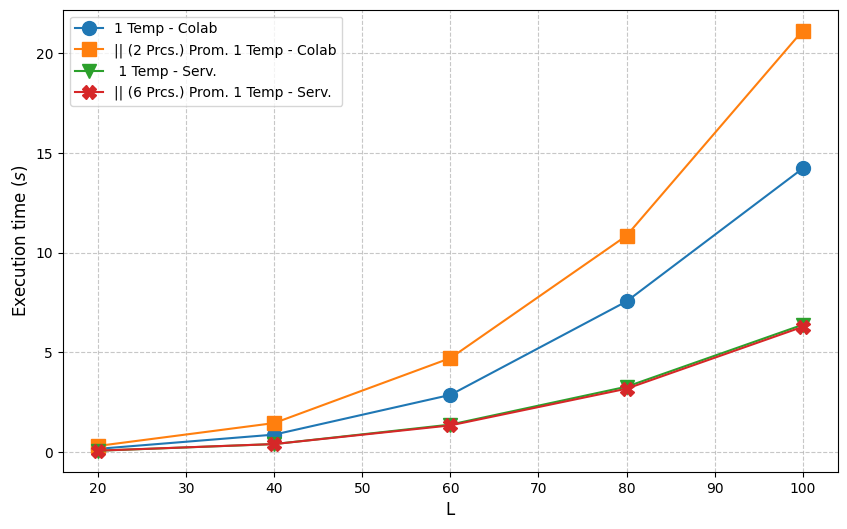

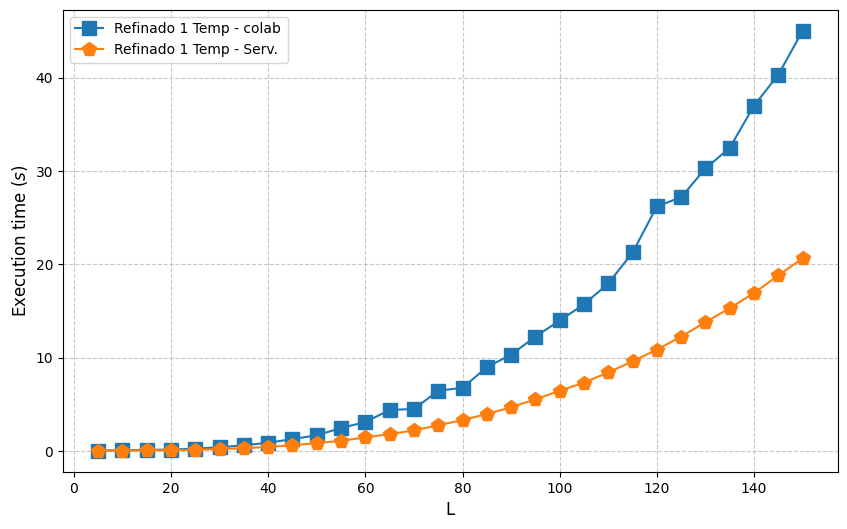

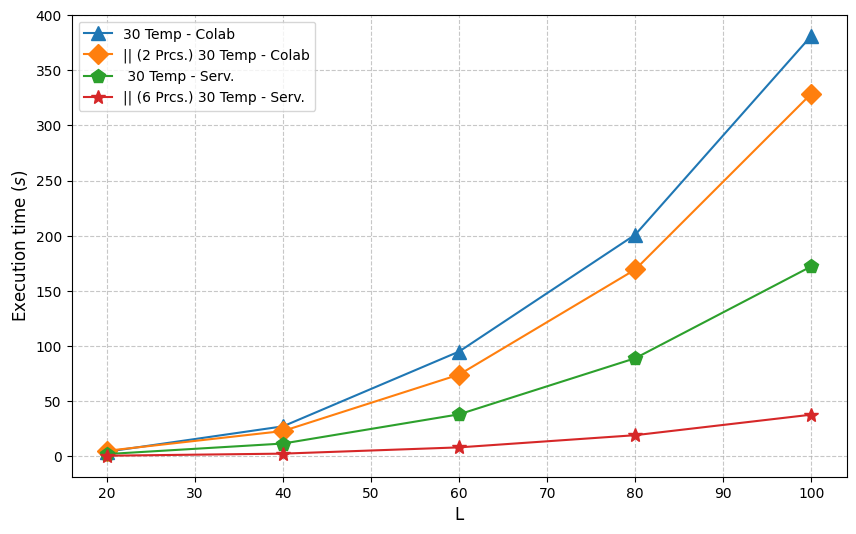

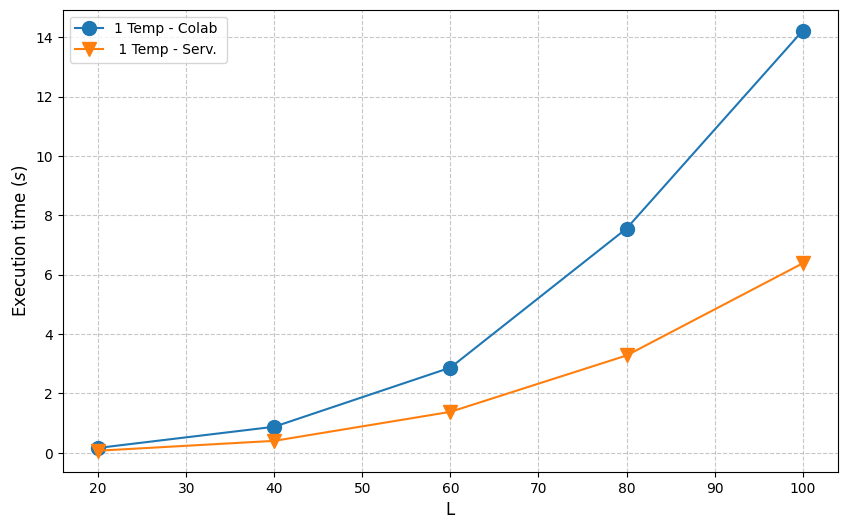

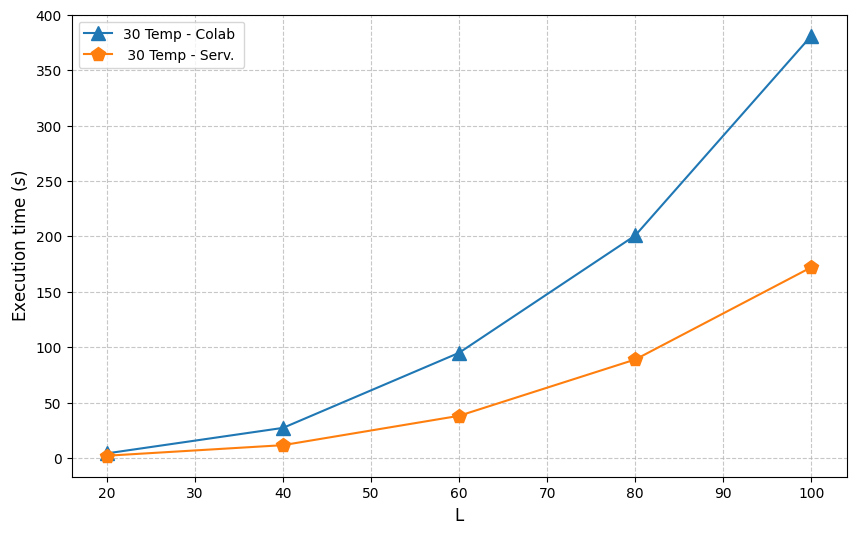

In [29]:
# archivos tiempo computo en colab
filenames = ["simulation_times_1.csv", "simulation_times_2.csv", "simulation_times_3.csv", "simulation_times_4.csv"]
# archivos tiempo computo en el servidor
filenames_par = ["simulation_times_1_paral.csv", "simulation_times_2_paral.csv", "simulation_times_3_paral.csv", "simulation_times_4_paral.csv" ]
# archivos de resultados de energia y magnetizacion del servidor, tanto por serie como por paralelización
filenames_result = ["observables_energia_magnetizacion.csv","resultados_energia_magnetizacion_paralelizacion.csv"]
#  archivos de resultados con el sistema ampliado a L=200
filenames_final = ["simulation_times_completo.csv","resultados_energia_magnetizacion_paralelizacion_completos.csv"]

df_1 = pd.read_csv(filenames[0], header=0)
df_2 = pd.read_csv(filenames[1], header=0)
df_3 = pd.read_csv(filenames[2], header=0)
df_4 = pd.read_csv(filenames[3], header=0)

df_1_par = pd.read_csv(filenames_par[0], header=0)
df_2_par = pd.read_csv(filenames_par[1], header=0)
df_3_par = pd.read_csv(filenames_par[2], header=0)
df_4_par = pd.read_csv(filenames_par[3], header=0)

df_result_1 = pd.read_csv(filenames_result[0], header=0)
df_result_2 = pd.read_csv(filenames_result[1], header=0)

df_final_1 = pd.read_csv(filenames_final[0], header=0)
df_final_2 = pd.read_csv(filenames_final[1], header=0)

# --- Graficar ---

labels = ["1 Temp - Colab", "Refinado 1 Temp - colab", "30 Temp - Colab", "|| (2 Prcs.) Prom. 1 Temp - Colab", "|| (2 Prcs.) 30 Temp - Colab" ]
labels_par = [" 1 Temp - Serv. ", "Refinado 1 Temp - Serv. ", " 30 Temp - Serv. ", "|| (6 Prcs.) Prom. 1 Temp - Serv.", "|| (6 Prcs.) 30 Temp - Serv."]
label_final = ["100 Temperaturas"]

plt.figure(figsize=(10, 6))

plt.plot(df_1["L"], df_1["Execution time (s)"], marker='o', markersize=10, label=labels[0])
#plt.plot(df_2["L"], df_2["Execution time (s)"], marker='s', markersize=10, label=labels[1])
#plt.plot(df_3["L"], df_3["Execution time (s)"], marker='^', markersize=10, label=labels[2])
plt.plot(df_4["L"], df_4["Execution internal time (s)"], marker='s', markersize=10, label=labels[3])
#plt.plot(df_4["L"], df_4["Execution external time (s)"], marker='D', markersize=10, label=labels[4])

plt.plot(df_1_par["L"], df_1_par["Execution time (s)"], marker='v', markersize=10, label=labels_par[0])
#plt.plot(df_2_par["L"], df_2_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[1])
#plt.plot(df_3_par["L"], df_3_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[2])
plt.plot(df_4_par["L"], df_4_par["Execution internal time (s)"], marker='X', markersize=10, label=labels_par[3])
#plt.plot(df_4_par["L"], df_4_par["Execution external time (s)"], marker='*', markersize=10, label=labels_par[4])

plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_1.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))

#plt.plot(df_1["L"], df_1["Execution time (s)"], marker='o', markersize=10, label=labels[0])
plt.plot(df_2["L"], df_2["Execution time (s)"], marker='s', markersize=10, label=labels[1])
#plt.plot(df_3["L"], df_3["Execution time (s)"], marker='^', markersize=10, label=labels[2])
#plt.plot(df_4["L"], df_4["Execution internal time (s)"], marker='s', markersize=10, label=labels[3])
#plt.plot(df_4["L"], df_4["Execution external time (s)"], marker='D', markersize=10, label=labels[4])

#plt.plot(df_1_par["L"], df_1_par["Execution time (s)"], marker='v', markersize=10, label=labels_par[0])
plt.plot(df_2_par["L"], df_2_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[1])
#plt.plot(df_3_par["L"], df_3_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[2])
#plt.plot(df_4_par["L"], df_4_par["Execution internal time (s)"], marker='X', markersize=10, label=labels_par[3])
#plt.plot(df_4_par["L"], df_4_par["Execution external time (s)"], marker='*', markersize=10, label=labels_par[4])

plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_2.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))

#plt.plot(df_1["L"], df_1["Execution time (s)"], marker='o', markersize=10, label=labels[0])
#plt.plot(df_2["L"], df_2["Execution time (s)"], marker='s', markersize=10, label=labels[1])
plt.plot(df_3["L"], df_3["Execution time (s)"], marker='^', markersize=10, label=labels[2])
#plt.plot(df_4["L"], df_4["Execution internal time (s)"], marker='s', markersize=10, label=labels[3])
plt.plot(df_4["L"], df_4["Execution external time (s)"], marker='D', markersize=10, label=labels[4])

#plt.plot(df_1_par["L"], df_1_par["Execution time (s)"], marker='v', markersize=10, label=labels_par[0])
#plt.plot(df_2_par["L"], df_2_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[1])
plt.plot(df_3_par["L"], df_3_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[2])
#plt.plot(df_4_par["L"], df_4_par["Execution internal time (s)"], marker='X', markersize=10, label=labels_par[3])
plt.plot(df_4_par["L"], df_4_par["Execution external time (s)"], marker='*', markersize=10, label=labels_par[4])

plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_3.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(df_1["L"], df_1["Execution time (s)"], marker='o', markersize=10, label=labels[0])
#plt.plot(df_2["L"], df_2["Execution time (s)"], marker='s', markersize=10, label=labels[1])
#plt.plot(df_3["L"], df_3["Execution time (s)"], marker='^', markersize=10, label=labels[2])
#plt.plot(df_4["L"], df_4["Execution internal time (s)"], marker='s', markersize=10, label=labels[3])
#plt.plot(df_4["L"], df_4["Execution external time (s)"], marker='D', markersize=10, label=labels[4])

plt.plot(df_1_par["L"], df_1_par["Execution time (s)"], marker='v', markersize=10, label=labels_par[0])
#plt.plot(df_2_par["L"], df_2_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[1])
#plt.plot(df_3_par["L"], df_3_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[2])
#plt.plot(df_4_par["L"], df_4_par["Execution internal time (s)"], marker='X', markersize=10, label=labels_par[3])
#plt.plot(df_4_par["L"], df_4_par["Execution external time (s)"], marker='*', markersize=10, label=labels_par[4])

plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_4.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))

#plt.plot(df_1["L"], df_1["Execution time (s)"], marker='o', markersize=10, label=labels[0])
#plt.plot(df_2["L"], df_2["Execution time (s)"], marker='s', markersize=10, label=labels[1])
plt.plot(df_3["L"], df_3["Execution time (s)"], marker='^', markersize=10, label=labels[2])
#plt.plot(df_4["L"], df_4["Execution internal time (s)"], marker='s', markersize=10, label=labels[3])
#plt.plot(df_4["L"], df_4["Execution external time (s)"], marker='D', markersize=10, label=labels[4])

#plt.plot(df_1_par["L"], df_1_par["Execution time (s)"], marker='v', markersize=10, label=labels_par[0])
#plt.plot(df_2_par["L"], df_2_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[1])
plt.plot(df_3_par["L"], df_3_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[2])
#plt.plot(df_4_par["L"], df_4_par["Execution internal time (s)"], marker='X', markersize=10, label=labels_par[3])
#plt.plot(df_4_par["L"], df_4_par["Execution external time (s)"], marker='*', markersize=10, label=labels_par[4])

plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_5.png", dpi=300)
plt.show()

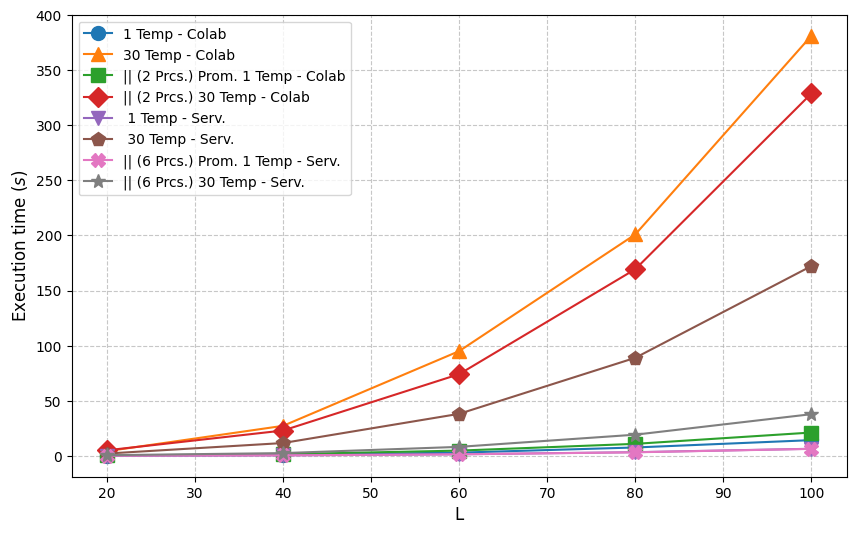

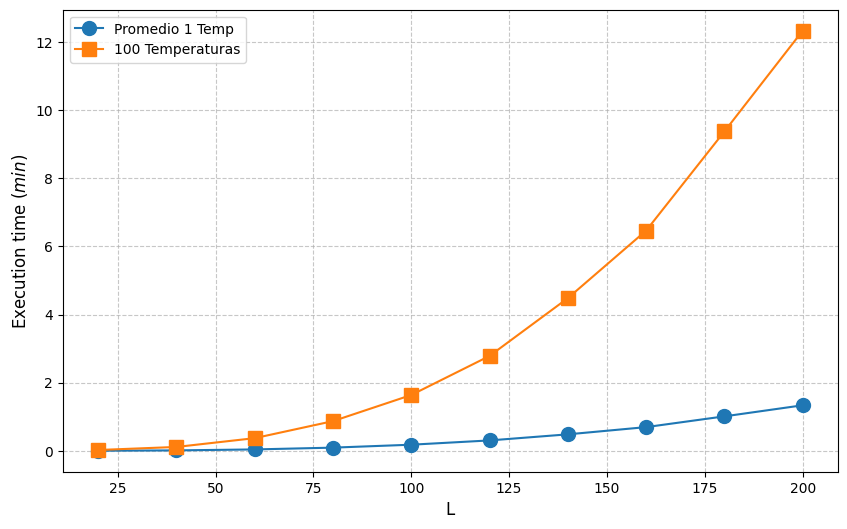

In [30]:
plt.figure(figsize=(10, 6))

plt.plot(df_1["L"], df_1["Execution time (s)"], marker='o', markersize=10, label=labels[0])
#plt.plot(df_2["L"], df_2["Execution time (s)"], marker='s', markersize=10, label=labels[1])
plt.plot(df_3["L"], df_3["Execution time (s)"], marker='^', markersize=10, label=labels[2])
plt.plot(df_4["L"], df_4["Execution internal time (s)"], marker='s', markersize=10, label=labels[3])
plt.plot(df_4["L"], df_4["Execution external time (s)"], marker='D', markersize=10, label=labels[4])

plt.plot(df_1_par["L"], df_1_par["Execution time (s)"], marker='v', markersize=10, label=labels_par[0])
#plt.plot(df_2_par["L"], df_2_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[1])
plt.plot(df_3_par["L"], df_3_par["Execution time (s)"], marker='p', markersize=10, label=labels_par[2])
plt.plot(df_4_par["L"], df_4_par["Execution internal time (s)"], marker='X', markersize=10, label=labels_par[3])
plt.plot(df_4_par["L"], df_4_par["Execution external time (s)"], marker='*', markersize=10, label=labels_par[4])

plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($s$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_6.png", dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
label_final = ["Promedio 1 Temp","100 Temperaturas"]

plt.plot(df_final_1["L"], df_final_1["Execution internal time (s)"]/60, marker='o', markersize=10, label=label_final[0])
plt.plot(df_final_1["L"], df_final_1["Execution external time (s)"]/60, marker='s', markersize=10, label=label_final[1])
plt.xlabel("L", fontsize=12)
plt.ylabel("Execution time ($min$)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.7)
plt.legend(loc="best", fontsize=10)
plt.savefig("resultados_tiempo_paralelizacion_7.png", dpi=300)
plt.show()

## <font color='lime'>**Nota**</font>:

En las próximas líneas de código. Se observan los datos generados de energía y magnetización en el servidor para comprobar que efectivamente se obtienen los mismos resultados que en Google colab.


In [34]:
filenames_energias =["resultados_energia_magnetizacion_paralelizacion.csv","resultados_energia_magnetizacion_paralelizacion_completos.csv"]

df1 = pd.read_csv(filenames_energias[0], header=0)
df2 = pd.read_csv(filenames_energias[1], header=0)

df2

,Temperatura,E_L20,M_L20,E_L40,M_L40,E_L60,M_L60,E_L80,M_L80,E_L100,...,E_L120,M_L120,E_L140,M_L140,E_L160,M_L160,E_L180,M_L180,E_L200,M_L200
0,0.1,-9.398569,1.000000,-8.362822,1.000000,-7.902417,1.000000,-7.177157,1.000000,-6.888188,...,-6.580371,1.000000,-6.144592,1.000000,-5.923887,1.000000,-5.516979,1.000000,-5.244727,1.000000
1,0.2,-9.398569,1.000000,-8.362822,1.000000,-7.902417,1.000000,-7.177157,1.000000,-6.888188,...,-6.580371,1.000000,-6.144592,1.000000,-5.923887,1.000000,-5.516979,1.000000,-5.244727,1.000000
2,0.3,-9.398569,1.000000,-8.362822,1.000000,-7.902417,1.000000,-7.177157,1.000000,-6.888188,...,-6.580371,1.000000,-6.144592,1.000000,-5.923887,1.000000,-5.516979,1.000000,-5.244727,1.000000
3,0.4,-9.398569,1.000000,-8.362822,1.000000,-7.902417,1.000000,-7.177157,1.000000,-6.888188,...,-6.580371,1.000000,-6.144592,1.000000,-5.923887,1.000000,-5.516979,1.000000,-5.244727,1.000000
4,0.5,-9.398569,1.000000,-8.362822,1.000000,-7.902417,1.000000,-7.177157,1.000000,-6.888188,...,-6.580371,1.000000,-6.144592,1.000000,-5.923887,1.000000,-5.516979,1.000000,-5.244727,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,9.6,-1.137708,0.018992,-1.099761,0.057108,-1.078555,0.056505,-1.002471,0.084053,-1.055964,...,-1.057800,0.121935,-1.018809,0.138007,-1.061167,0.161866,-1.024234,0.185606,-1.024615,0.202841
96,9.7,-1.000000,0.003912,-1.008686,0.042377,-1.036494,0.042077,-1.003995,0.080837,-1.023988,...,-1.053318,0.121485,-1.051786,0.142570,-1.051869,0.154496,-1.026296,0.177582,-1.019127,0.199551
97,9.8,-1.107625,0.036107,-1.017036,0.033594,-1.016079,0.063474,-1.005386,0.071681,-1.024863,...,-1.003567,0.111101,-1.012616,0.138825,-1.019663,0.157342,-1.014134,0.174609,-1.021193,0.200468
98,9.9,-1.097463,0.032871,-1.000000,0.046010,-1.000000,0.074431,-1.002151,0.085637,-1.017534,...,-1.001220,0.114309,-1.006163,0.136717,-1.015218,0.162320,-1.028604,0.178962,-1.001366,0.197892


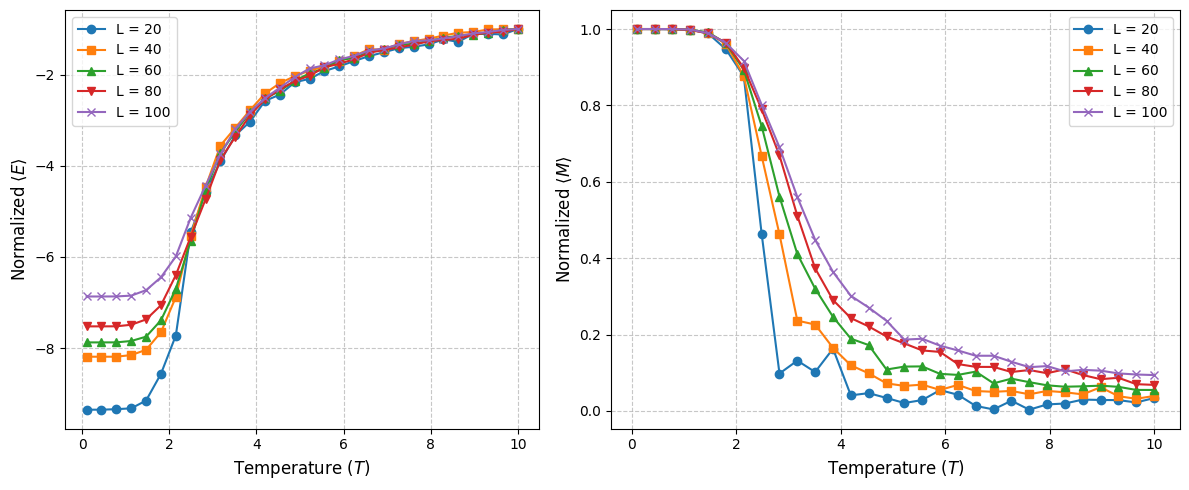

In [32]:
L = [20, 40, 60, 80, 100]

fig, axes = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Energía
for l, marker in zip(L, ['o', 's', '^', 'v', 'x']):
    energias = df1[f"E_L{l}"]
    axes[0].plot(df1["Temperatura"], energias / abs(energias.max()),
                 label=f"L = {l}", linestyle='-', marker=marker)

axes[0].set_xlabel("Temperature $(T)$", fontsize=12)
axes[0].set_ylabel(r"Normalized $\langle E \rangle$", fontsize=12)
axes[0].legend(loc="best", fontsize=10)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Magnetización
for l, marker in zip(L, ['o', 's', '^', 'v', 'x']):
    mags = df1[f"M_L{l}"]
    axes[1].plot(df1["Temperatura"], mags / abs(mags.max()),
                 label=f"L = {l}", linestyle='-', marker=marker)

axes[1].set_xlabel("Temperature $(T)$", fontsize=12)
axes[1].set_ylabel(r"Normalized $\langle M \rangle$", fontsize=12)
axes[1].legend(loc="best", fontsize=10)
axes[1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


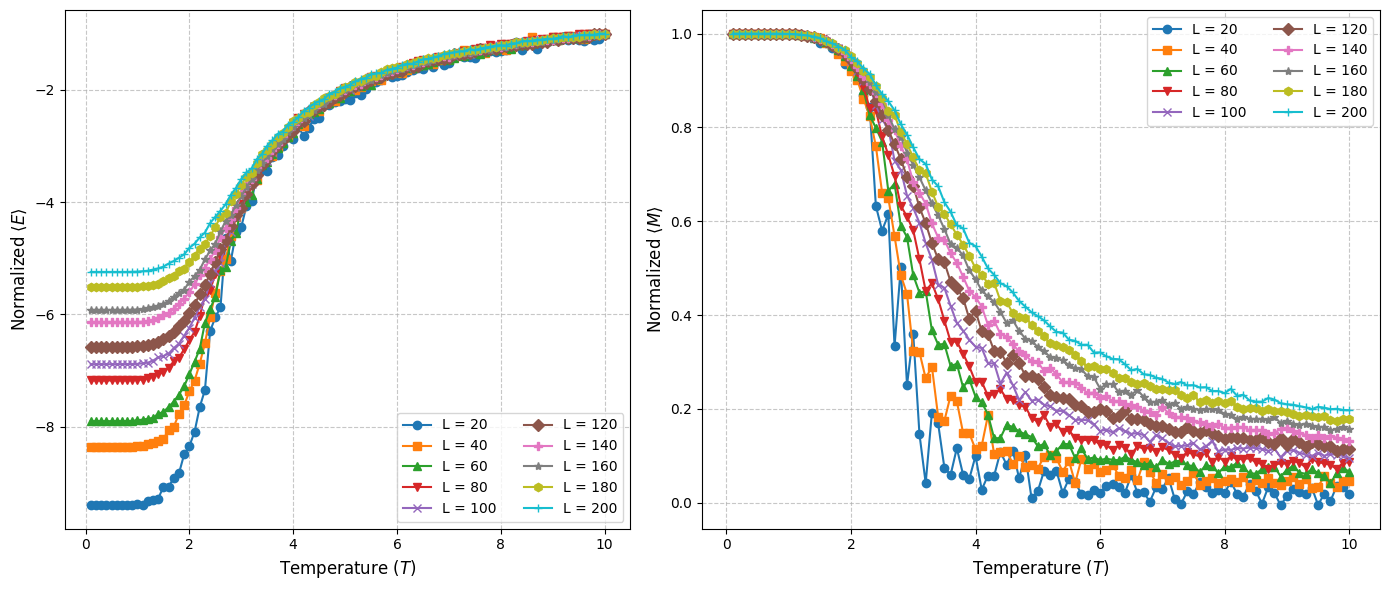

In [28]:
L = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
markers = ['o', 's', '^', 'v', 'x', 'D', 'P', '*', 'h', '+']  # 10 markers diferentes

fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.2]})

# Energía
for l, marker in zip(L, markers):
    energias = df2[f"E_L{l}"]
    axes[0].plot(df2["Temperatura"], energias / abs(energias.max()),
                 label=f"L = {l}", linestyle='-', marker=marker)

axes[0].set_xlabel("Temperature $(T)$", fontsize=12)
axes[0].set_ylabel(r"Normalized $\langle E \rangle$", fontsize=12)
axes[0].legend(loc="best", fontsize=10, ncol=2)
axes[0].grid(True, linestyle="--", alpha=0.7)

# Magnetización
for l, marker in zip(L, markers):
    mags = df2[f"M_L{l}"]
    axes[1].plot(df2["Temperatura"], mags / abs(mags.max()),
                 label=f"L = {l}", linestyle='-', marker=marker)

axes[1].set_xlabel("Temperature $(T)$", fontsize=12)
axes[1].set_ylabel(r"Normalized $\langle M \rangle$", fontsize=12)
axes[1].legend(loc="best", fontsize=10, ncol=2)
axes[1].grid(True, linestyle="--", alpha=0.7)

plt.tight_layout()
plt.savefig("EnergiaYMagnetizacion_paralelizacion_200.png", dpi=300)
plt.show()